<body style="color:white">
<h1 align='center'><font size="+3" color=#CA00BA>Introduction</font></h1>

<h3 align='center'><font>In this <font color=#CA00BA>notebook</font> , we are going to <font color=#A504FE>Generate Art</font> using <font color=#CA00BA>GANS</font>. Explaining it in a brief way , it is a <font color=#FE046A>Artist</font> who forges <font color=#04B0FE>Monet's</font> paintings , but using random normal picture that is assigned to him. YES you can have your own portrait made by <font color=#04B0FE>Monet</font> !!! However , this <font color=#FE046A>Artist</font> has both his ears.  
</font></h3>
   
</body>

In [1]:
# !pip install --upgrade tensorflow

In [2]:
# %tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Device:', tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy()
# print('Number of replicas:', strategy.num_replicas_in_sync)


Found GPU at: /device:GPU:0


In [3]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-_s2f26x9
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-_s2f26x9
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=60ed9d9d519a871be664755ed747e9bf3d4b3291d7c7c29bc4a5286eacfa55f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-jvcdb2l1/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [4]:
import tensorflow_datasets as tfds
 
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
#from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from tensorflow.keras.models import Model

AUTOTUNE = tf.data.AUTOTUNE

<body style="color:white">
<h1 align='center'><font size="+3" color=#FF2C00>Loading the Data:</font></h1>

<h3 align='center'><font> We are using the <font color=#CA00BA>monet2photo</font> data from <font color=#FF0000>TensorFlow Datasets</font> , from the <font color=#FF006E>cycle_gan</font> category. However we are inverting the data , that is photo to <font color=#00BAFF>Monet</font>. 
</font></h3>
   
</body>

In [5]:
dataset, metadata = tfds.load('cycle_gan/monet2photo',
                              with_info=True, as_supervised=True,try_gcs=True)

train_normal, train_van = dataset['trainB'], dataset['trainA']
test_normal, test_van = dataset['testB'], dataset['testA']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteGJCL3R/cycle_gan-trainA.tfrecord


  0%|          | 0/1072 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteGJCL3R/cycle_gan-trainB.tfrecord


  0%|          | 0/6287 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteGJCL3R/cycle_gan-testA.tfrecord


  0%|          | 0/121 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteGJCL3R/cycle_gan-testB.tfrecord


  0%|          | 0/751 [00:00<?, ? examples/s]

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0. Subsequent calls will reuse this data.


In [6]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_SHAPE = (256,256,3)

### Preprocessing the Images. 

In [7]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [8]:
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [9]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [10]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [11]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [12]:
train_normal = train_normal.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_van = train_van.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_normal = test_normal.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_van = test_van.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

* Adding jitter to image data. 

In [13]:
sample_normal = next(iter(train_normal))
sample_van = next(iter(train_van))

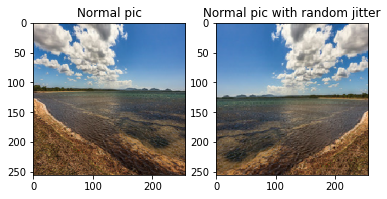

In [14]:
plt.subplot(121)
plt.title('Normal pic')
plt.imshow(sample_normal[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Normal pic with random jitter')
plt.imshow(random_jitter(sample_normal[0]) * 0.5 + 0.5)

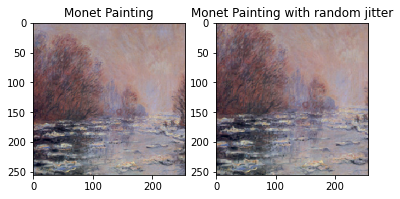

In [46]:
plt.subplot(121)
plt.title('Monet Painting')
plt.imshow(sample_van[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet Painting with random jitter')
plt.imshow(random_jitter(sample_van[0]) * 0.5 + 0.5)

<body style="color:white">
<h1 align='center'><font size="+3" color=#FF2C00>Setting the Models:</font></h1>

<h3 align='center'><font>We are implementing CycleGan , with a modified UNET model as a generator , and a PatchGan block as a Discriminator. The difference between a normal block and a GAN block is that it uses a InstanceNormalization.</font>. 
</font></h3>
   
</body>

In [16]:
OUTPUT_CHANNELS = 3

In [17]:
def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  """Downsamples an input.
  Conv2D => Batchnorm => LeakyRelu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer
  Returns:
    Downsample Sequential Model
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


In [18]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(sample_van[0], 0))
print (down_result.shape)

(1, 128, 128, 3)


In [19]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [20]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


### The Generator :

There are 2 generators (A and B) and 2 discriminators (X and Y) being trained here.

Generator G learns to transform image X to image Y.  (A:X−>Y) 
Generator F learns to transform image Y to image X.  (B:Y−>X) 
Discriminator D_X learns to differentiate between image X and generated image X (B(Y)).
Discriminator D_Y learns to differentiate between image Y and generated image Y (A(X)).

In [21]:
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = tf.keras.layers.BatchNormalization()(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = tf.keras.layers.BatchNormalization()(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [22]:
def define_generator(image_shape, n_resnet=4):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(32, (8,8), padding='same', kernel_initializer=init)(in_image)
	g =tf.keras.layers.BatchNormalization()(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tf.keras.layers.BatchNormalization()(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g =tf.keras.layers.BatchNormalization()(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(128, g)
	# u128
	g = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tf.keras.layers.BatchNormalization()(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tf.keras.layers.BatchNormalization()(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (8,8), padding='same', kernel_initializer=init)(g)
	g = tf.keras.layers.BatchNormalization()(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [23]:
generator = define_generator(IMG_SHAPE)
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  6176        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 256, 256, 32  128        ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

* The generator Architecture.

In [24]:


def discriminator(norm_type='batchnorm', target=True):
  """PatchGan discriminator model (https://arxiv.org/abs/1611.07004).
  Args:
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
    target: Bool, indicating whether target image is an input or not.
  Returns:
    Discriminator model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization(axis=-1)(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)


In [25]:
generator_a = define_generator(IMG_SHAPE)
generator_b = define_generator(IMG_SHAPE)

discriminator_x = discriminator(norm_type='batchnorm', target=False)
discriminator_y = discriminator(norm_type='batchnorm', target=False)

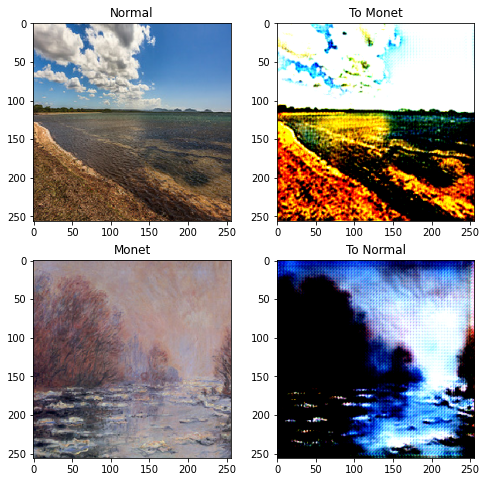

In [45]:
to_van = generator_a(sample_normal)
to_normal = generator_b(sample_van)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_normal, to_van, sample_van, to_normal]
title = ['Normal', 'To Monet', 'Monet', 'To Normal']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

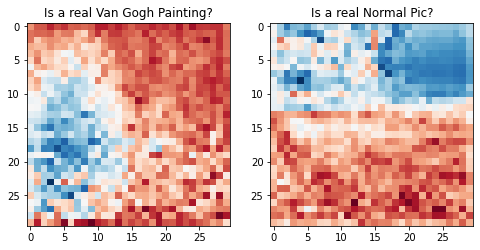

In [27]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real Van Gogh Painting?')
plt.imshow(discriminator_y(sample_van)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real Normal Pic?')
plt.imshow(discriminator_x(sample_normal)[0, ..., -1], cmap='RdBu_r')

plt.show()

### Calculating the loss.

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input x and the target y pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

In [28]:
LAMBDA = 8

In [29]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [31]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [32]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [33]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

* Initializing the optimizers for all the generators and the discriminators.



In [34]:
generator_a_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.7)
generator_b_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.7)
discriminator_x_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

* Setting checkpoints

In [35]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_a=generator_a,
                           generator_b=generator_b,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_a_optimizer=generator_a_optimizer,
                           generator_b_optimizer=generator_b_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [36]:
EPOCHS = 10

<body style="color:white">
<h1 align='center'><font size="+3" color=#03379A>Training the Models:</font></h1>

<h3 align='center'><font>We are training the model with <font color=#F19701>10 epochs</font>. The original CycleGan paper was also trained with <font color=#F13A01>200 epochs</font>.</font>
</font></h3>
   
</body>

In [37]:
def generate_images(model, test_input):
  prediction = model(test_input)      
  plt.figure(figsize=(12, 12))
 
  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Painting']
 
 
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
  return prediction

### 4 steps that are in the training loop

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [38]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_a(real_x, training=True)
    cycled_x = generator_b(fake_y, training=True)

    fake_x = generator_b(real_y, training=True)
    cycled_y = generator_a(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_b(real_x, training=True)
    same_y = generator_a(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_a_loss = generator_loss(disc_fake_y)
    gen_b_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_a_loss = gen_a_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_b_loss = gen_b_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_a_gradients = tape.gradient(total_gen_a_loss, 
                                        generator_a.trainable_variables)
  generator_b_gradients = tape.gradient(total_gen_b_loss, 
                                        generator_b.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_a_optimizer.apply_gradients(zip(generator_a_gradients, 
                                            generator_a.trainable_variables))

  generator_b_optimizer.apply_gradients(zip(generator_b_gradients, 
                                            generator_b.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

* We are training over the same picture so that we can keep a track on the progress , over each epoch.And the checkpoints are saved after 5 epochs. 

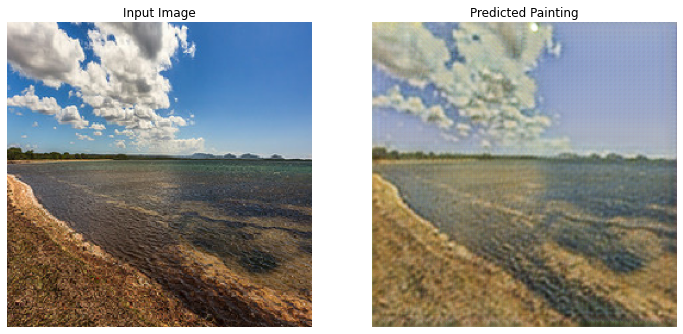

Time taken for epoch 10 is 865.0545196533203 sec



In [39]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_normal, train_van)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_a, sample_normal)

#   if (epoch + 1) % 5 == 0:
#     ckpt_save_path = ckpt_manager.save()
#     print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
#                                                          ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

<body style="color:white">
<h1 align='center'><font size="+3" color=#F1016D>Forging the Great Artistic Style:</font><font size="+3" color=#03379A> Generating on test data !!</font></h1>

<h3 align='center'><font>Here we are generating the paintings using the test data , and we can see how the <font color=#CA00BA>GAN</font> generates <font color=#04B0FE>Monet</font> style paintings from normal random pictures.

<font color=#F10101>Note:</font> The results might have been better if we had used more epochs </font>. 
</font></h3>
   
</body>

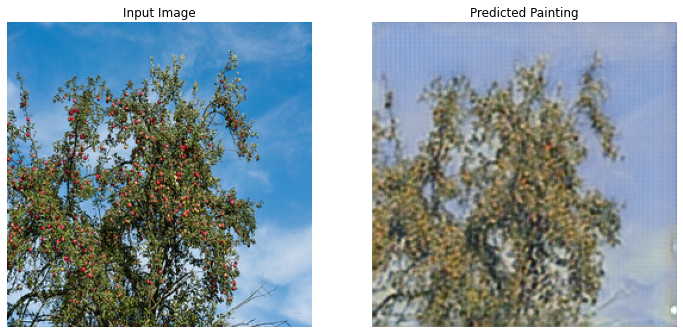

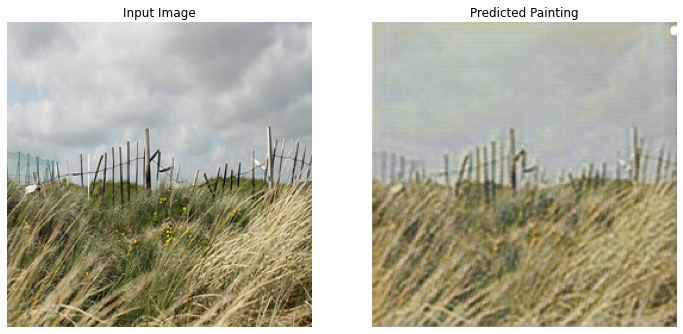

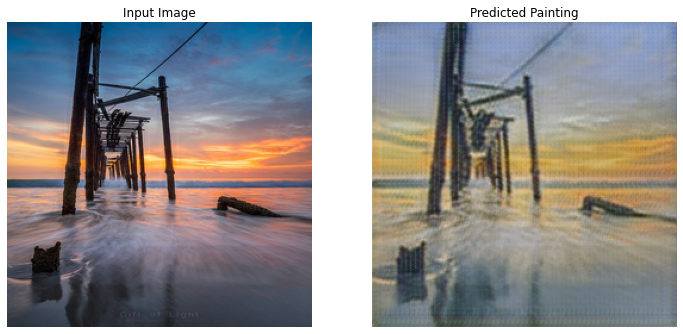

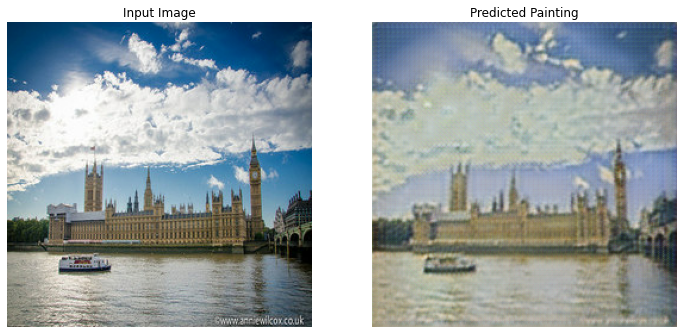

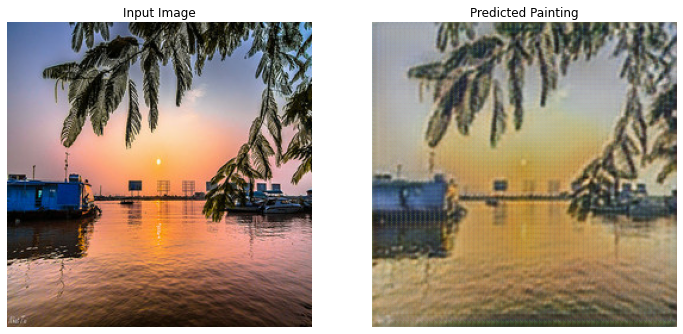

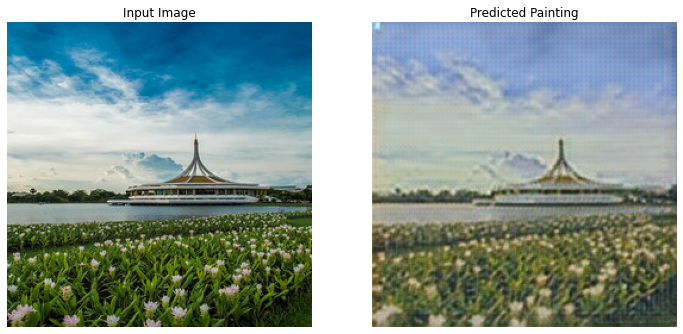

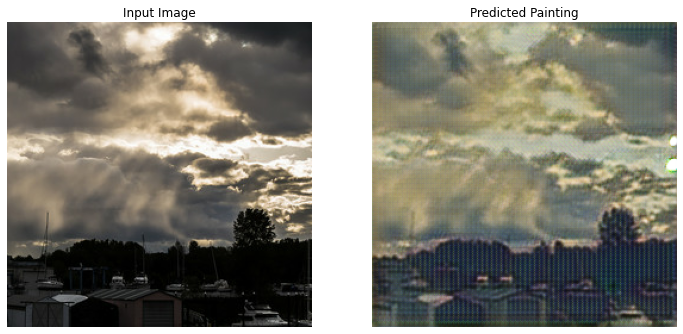

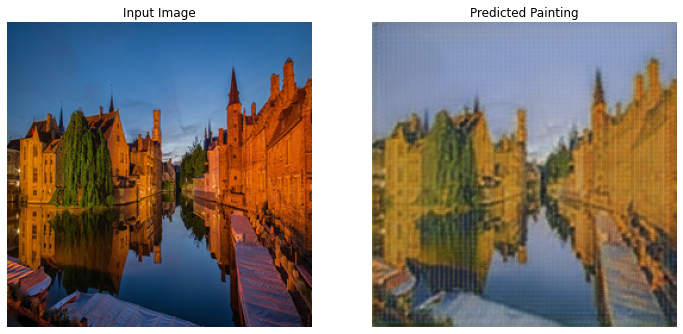

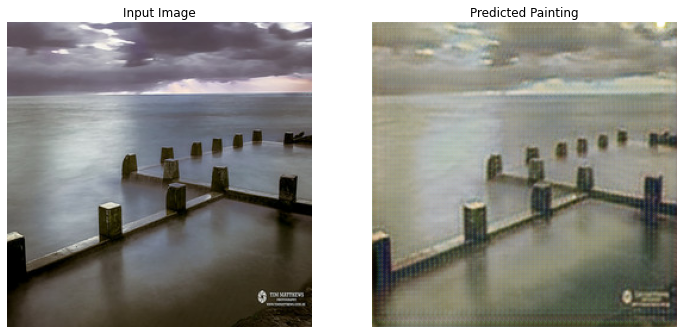

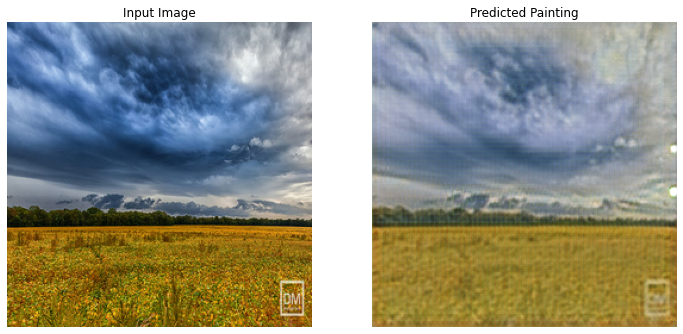

In [40]:
for inp in test_normal.take(10):
  generate_images(generator_a, inp)

In [41]:
from tensorflow import keras
generator_Save=generator_a.save('/content/monet.h5')

<body style="color:white">
<h1 align='center'><font size="+3" color=#F1016D>Testing the GANs:</font><font size="+3" color=#03379A> Generating with any picture from internet !!</font></h1>

<h3 align='center'><font>In the following cell you can paste the image address and then run the code , and it will generate the Monet style image. 
</font></h3>
   
</body>

In [42]:
model_load = keras.models.load_model('/content/monet.h5')

In [43]:
imgurl="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/687px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg"

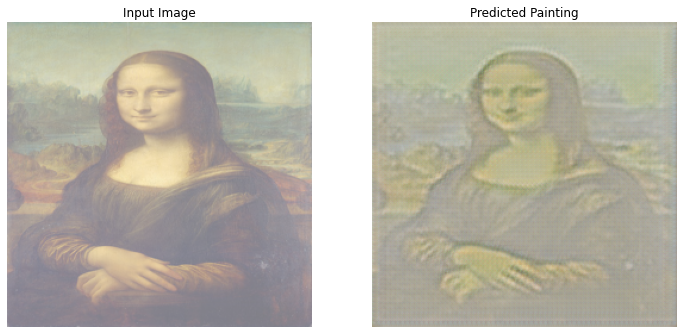

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[0.46441275, 0.4736623 , 0.2397875 ],
         [0.50816464, 0.48488733, 0.22416964],
         [0.5257111 , 0.48274654, 0.26379943],
         ...,
         [0.3982015 , 0.42476383, 0.2774038 ],
         [0.38741112, 0.37494677, 0.21042491],
         [0.35435602, 0.2976266 , 0.15552783]],

        [[0.49567178, 0.47465357, 0.2914553 ],
         [0.48394924, 0.4582937 , 0.27000695],
         [0.49400893, 0.44226715, 0.23544417],
         ...,
         [0.3635646 , 0.38745457, 0.28546083],
         [0.36464003, 0.36512277, 0.19291866],
         [0.33342788, 0.31594622, 0.15832964]],

        [[0.5180036 , 0.52805984, 0.32768837],
         [0.51188564, 0.4369759 , 0.2293555 ],
         [0.49693918, 0.435105  , 0.21235117],
         ...,
         [0.45709425, 0.44501624, 0.31002346],
         [0.4383008 , 0.4419983 , 0.2997979 ],
         [0.39543405, 0.3675505 , 0.2203983 ]],

        ...,

        [[0.2899617 , 0.28766695, 

In [44]:
from urllib.request import urlopen
from PIL import Image
import cv2
from numpy import asarray
from scipy import misc

img = Image.open(urlopen(imgurl))
basewidth = 256
#wpercent = (basewidth / float(img.size[0]))
hsize = 256#int((float(img.size[1]) * float(wpercent)))
img = img.resize((basewidth, hsize))
#img.save('resized_image.jpg')
#img.show()
#img = cv2.cvtColor(np.float32(img), cv2.COLOR_RGB2BGR)
#image=misc.imread(img)
img=asarray(img)
img.astype('float32')
img=img/255.0
image_tensor = tf.convert_to_tensor(img, dtype=tf.float64)
image_tensor = tf.expand_dims(image_tensor, 0)
generate_images(model_load, image_tensor)

<h1 align="center" > THE END</h3> 